# Libraries 

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [3]:
import cv2  #openCV on python
import dlib #library for facial detection
import face_recognition #wrapper of dlib
import os
import shutil
import pathlib
import matplotlib.pyplot as plt #cv2.imshow error on GG colab and we use alternative of plt
import numpy as np
import pandas as pd 
import time 
import datetime
import glob

<br>

# Convert h5 to tensorflow lite

## Convert 

Path to model

In [10]:
age_model_path = "D:\\01_PYTHON\\05_CoderS\\23_Age_Gender_Prediction_VM\\script_models\\xception_age_id.h5"

Load model to Jupyter Notebook

In [11]:
xception_age_model = load_model(age_model_path)

Convert h5 file to tflite format

In [12]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(xception_age_model)
tflite_model = converter.convert()

Save tflite mode with name and path

In [13]:
open("xception_age_id.tflite", "wb").write(tflite_model)

94362264

Reuse model is loaded or loading it from file 

In [11]:
#Load tflite from file
interpreter = tf.lite.Interpreter(model_path="D:\\01_PYTHON\\05_CoderS\\23_Age_Gender_Prediction_VM\\app\\models\\xception_age_id.tflite")

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

Allocating memory for interpreter

In [12]:
interpreter.allocate_tensors()

Set input and output details

In [13]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [14]:
input_details

[{'name': 'input_2',
  'index': 2,
  'shape': array([  1, 299, 299,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [23]:
output_details

[{'name': 'Identity',
  'index': 0,
  'shape': array([  1, 128]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'Identity_1',
  'index': 1,
  'shape': array([1, 8]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [15]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']

In [16]:
input_shape

array([  1, 299, 299,   3])

## Run tflite model 

Preprocessing input format

In [4]:
def preprocess_image(image):
    """
    Import image, pre-process it before push it in model
    :param image:
    :return: processed image
    """
    # de-noise parameter, higher is stronger
    denoise = 5
    processed_img = cv2.fastNlMeansDenoisingColored(image, None, denoise, 10, 7, 21)
    ## change image to HSV color space to brighten it up
    # hsvImg = cv2.cvtColor(processed_img, cv2.COLOR_RGB2HSV)
    # value = 50
    # vValue = hsvImg[..., 2]
    # hsvImg[..., 2] = np.where((255 - vValue) < value, 255, vValue + value)
    # processed_img = cv2.cvtColor(hsvImg, cv2.COLOR_HSV2RGB)
    resized = cv2.resize(processed_img, (299, 299), interpolation=cv2.INTER_AREA) # resize image to 299x299, input of Xception model
    resized = np.expand_dims(resized, axis=0)
    img = resized / 255.
    return img

Get image from folder

In [5]:
img = cv2.imread("D:\\01_PYTHON\\05_CoderS\\78_Ads_Targeted_Audience\\datasets\\UTKface\\utkface\\gender\\female\\29_1_1_20170112204807283.jpg")

Display image to test

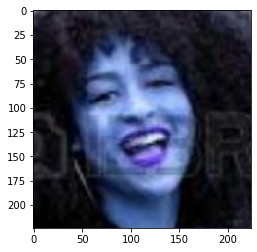

In [6]:
plt.imshow(img)

Preprocess image

In [7]:
img = preprocess_image(img)

**Predicting with tflite**

Convert image to tensor 

In [17]:
input_data = np.array(img, dtype=np.float32)

In [18]:
input_tensor = tf.convert_to_tensor(img, np.float32)

Set input of interpreter

In [19]:
interpreter.set_tensor(input_details[0]['index'], input_tensor)

Invoking

In [20]:
interpreter.invoke()

Get output from interpreter

In [21]:
output_data = interpreter.get_tensor(output_details[0]['index'])

If output has more than 1 port

In [24]:
# output_data = interpreter.get_tensor(output_details[1]['index'])

In [25]:
# output format from architect
output_data

array([[3.6488520e-05, 1.4799836e-02, 7.7228087e-01, 2.0659888e-01,
        6.1159679e-03, 1.6572299e-04, 1.1836099e-06, 1.0359430e-06]],
      dtype=float32)

<br>

# Convert h5 to pb 

Importance note: this method is only working with tensorflow 1.x. Please change version before converting

In [ ]:
import tensorflow as tf

Check version of current tensorflow

In [ ]:
tf.__version__

In [ ]:
import tensorflow as tf
from keras import backend as K

Path to model

In [ ]:
age_model_path = "D:\\01_PYTHON\\05_CoderS\\23_Age_Gender_Prediction_VM\\script_models\\xception_age_v1.h5"

Load model to Jupyter Notebook

In [ ]:
xception_age_model = load_model(age_model_path)

Init function

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

Convert and saving model as pb and pbtxt file

In [ ]:
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in xception_age_model.outputs])
tf.train.write_graph(frozen_graph, './', 'xor.pbtxt', as_text=True)
tf.train.write_graph(frozen_graph, './', 'xor.pb', as_text=False)

<br>

# Change structure of layers of Model

Absolute path to model

In [ ]:
age_model_path = "D:\\01_PYTHON\\05_CoderS\\23_Age_Gender_Prediction_VM\\script_models\\xception_age.h5"

Load model

In [ ]:
xception_age_model = load_model(age_model_path)

In [ ]:
xception_age_model.summary()

In [3]:
Count layers of model

SyntaxError: invalid syntax (<ipython-input-3-31403da3da29>, line 1)

In [ ]:
len(xception_age_model.layers)

Get model from input to layer 5 from bottom

In [ ]:
xception_origin = Model(xception_age_model.inputs, xception_age_model.layers[-5].output)

In [ ]:
xception_origin.summary()

Create new output of model from other layers

In [ ]:
xception_last_age = Model(xception_age_model.get_layer("input_2").input, 
                          [xception_age_model.get_layer("dense_15").output, xception_age_model.get_layer("dense_11").output])

In [ ]:
xception_last_age.summary()

Save new models

In [ ]:
xception_last_age.save("D:\\01_PYTHON\\05_CoderS\\23_Age_Gender_Prediction_VM\\script_models\\xception_age_id.h5")

In [37]:
type(os.path.join(os.getcwd(), "a"))

str